In [1]:
import uuid
import os
from collections import Counter
import json
from itertools import combinations
import io

import re

from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import Image, display

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import pydot
import networkx as nx
from networkx.readwrite import json_graph

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

import gensim
# import gensim.downloader

# from tmtoolkit.topicmod.evaluate import metric_coherence_gensim

sns.set(rc={'figure.figsize':(12,8)})

phrase_file = 'lecture_concepts_CS_241.csv'
# context_file = 'contexts_CS_410.json'
context_file = 'contexts_CS_241.json'

context = json.load(open(context_file, 'r'))
tid2lecNum = {}
lecNum2lecTitle = {}
for d in context:
    for c in d['contexts']:
        # tid2lecNum[c['transcription']] = c['lecture_num']
        tid2lecNum[c['transcription']] = c['lecture'].split('Lec')[-1] # for CS 241, consider segments of a lecture as a single lecture
        lecNum2lecTitle[c['lecture_num']] = c['lecture']


In [2]:
tid2lecNum

{'0313c4b8-b3cb-47c4-893c-bcb27ce990a3': '13-Q07',
 '040bf74d-c21b-4d61-a0f9-38e3b2cc4d67': '13-Q06',
 '1e783a67-b8be-40c2-9441-09e0f8e0a1f8': '13-Q07',
 '34f5f15f-13e2-472c-a71d-7653231e61e9': '13-Q06',
 '7515c79a-82da-4b96-90bc-a6cbb5ee3e36': '13-Q01',
 'c4e34ebf-4fec-4220-80f0-55bff9d28117': '13-Q09',
 'fbf50bc7-ae3a-4768-be0b-502c42ec38cc': '13-Q07',
 '1df72ccf-c3d4-4939-945b-2a60fbbe7490': '14-Q02',
 '48c308bd-22a2-405e-9437-75a1df1794fe': '14-Q03',
 '6c7e145f-442c-430a-a17d-cd3630fbce96': '14-Q07',
 '798dfc68-4c27-4294-b5d2-be44d2f85516': '14-Q06',
 '868deb37-9bd1-4419-a9ac-e164d0b078da': '14-Q04',
 'a73bb722-a006-40e7-ba5b-1402cd135b37': '14-Q05',
 'b681599f-1223-4f55-aca4-e57ac7b4b6cd': '14-Q05',
 'baa2188b-1097-4e5f-9fed-2ae8b4b6eff9': '14-Q08',
 'c13af5c8-7804-4b6a-ab8f-1f0d32ac4c29': '14-Q07',
 'da7958fa-52cd-4d05-93a6-42c5aaca70a7': '14-Q05',
 '068de9f9-f0f5-4140-8da8-7ba0ac3aa5c3': '15-Q02',
 '079e15d0-be66-4f0c-a3b4-bb9079ea8eea': '15-Q03',
 '160c1e41-f1c4-4ca1-9264-636d9

In [3]:
# evaluating the model using coherence score
class TokenGenerator:
    def __init__(self, documents, stopwords=[]):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile(r"(?u)\b\w\w+\b")

    def __iter__(self):
        # print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall(doc):
                if tok.lower() in self.stopwords:
                    tokens.append("<stopword>")
                elif len(tok) >= 2:
                    tokens.append(tok.lower())
            yield tokens


def calculate_coherence(w2v_model, term_rankings):
    terms = list(w2v_model.wv.key_to_index.keys())
    # print(terms)
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations(term_rankings[topic_index], 2):
            if pair[0] in terms and pair[1] in terms:
                pair_scores.append(w2v_model.wv.similarity(pair[0], pair[1]))
                pair_scores.append(w2v_model.wv.similarity(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


def get_descriptor(all_terms, H, topic_index, top):
    # reverse sort the values to sort the indices
    top_indices = np.argsort(H[:, topic_index])[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = set()
    for term_index in top_indices[0:top]:
        # print(top_indices)
        # print(len(all_terms))
        terms = all_terms[term_index].split()
        top_terms.update(terms)
    print(top_terms)
    return list(top_terms)


def get_coherence_scores(topic_models):
    texts = (df_phrase['phrases_both'] + ', ' +
             df_phrase['phrases_caption'] + ', ' + df_phrase['phrases_video']).values
    docgen = TokenGenerator(texts)
    w2v_model = gensim.models.Word2Vec(
        docgen, vector_size=500, min_count=1, sg=1)

    # print("Model has %d terms" % len(w2v_model.wv.key_to_index))
    # terms = list({t for d in docgen for t in d})
    terms = list(word2interaction.keys())
    # print(terms)

    k_values = []
    coherences = []
    for (k, W, H) in topic_models:
        # Get all of the topic descriptors - the term_rankings, based on top 10 terms
        term_rankings = []
        for topic_index in range(k):
            term_rankings.append(get_descriptor(terms, W, topic_index, 10))
        # Now calculate the coherence based on our Word2vec model
        k_values.append(k)
        coherences.append(calculate_coherence(w2v_model, term_rankings))
        print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    return k_values, coherences

## Lecture-level

### Load Data

In [3]:
df_phrase = pd.read_csv(phrase_file, sep='\t').fillna('')

df_phrase['lecture_number'] = df_phrase['transcriptionid'].apply(lambda x: tid2lecNum[x])

df_phrase.head(2)

,transcriptionid,videoid,phrases_both,phrases_caption,phrases_video,lecture_number
0,0313c4b8-b3cb-47c4-893c-bcb27ce990a3,6bcd8791-b067-4442-b1c5-690b51547ecf,,"peter mutex lock, mutex lock, whole load, main...",,13
1,040bf74d-c21b-4d61-a0f9-38e3b2cc4d67,cc52fb01-ec70-48ed-ac3c-0d0f5009aee9,,"condition variable, peter mutex lock, mutex lo...",,13


In [4]:
lecNum2phrasesBoth = dict(
    zip(df_phrase['lecture_number'], df_phrase['phrases_both']))
lecNum2phrasesCaption = dict(
    zip(df_phrase['lecture_number'], df_phrase['phrases_caption']))
lecNum2phrasesVideo = dict(
    zip(df_phrase['lecture_number'], df_phrase['phrases_video']))

lecNum2phrasesAll = {}
word_count = Counter()
for i in range(1, 51):
    if i not in lecNum2phrasesBoth:
        lecNum2phrasesAll[i] = {
            'both': {},
            'caption': {},
            'video': {},
        }
    else:
        lecNum2phrasesAll[i] = {
            'both': lecNum2phrasesBoth[i].split(', '),
            'caption': lecNum2phrasesCaption[i].split(', '),
            'video': lecNum2phrasesVideo[i].split(', '),
        }
        word_count+=(Counter(lecNum2phrasesBoth[i].split(', ')))
        word_count+=(Counter(lecNum2phrasesCaption[i].split(', ')))
        word_count+=(Counter(lecNum2phrasesVideo[i].split(', ')))

word_count.pop('')


76

In [5]:
# word_count.most_common(60)

In [6]:
word2interaction = {}
for w, c in word_count.most_common(60):
    inters = []
    for i in lecNum2phrasesAll:
        if w in lecNum2phrasesAll[i]['both']:
            inters.append(3)
        elif w in lecNum2phrasesAll[i]['caption']:
            inters.append(2)
        elif w in lecNum2phrasesAll[i]['video']:
            inters.append(1)
        else:
            inters.append(0)

    word2interaction[w] = inters

# convert to array
word2interaction = {k: np.array(word2interaction[k]) for k in word2interaction}

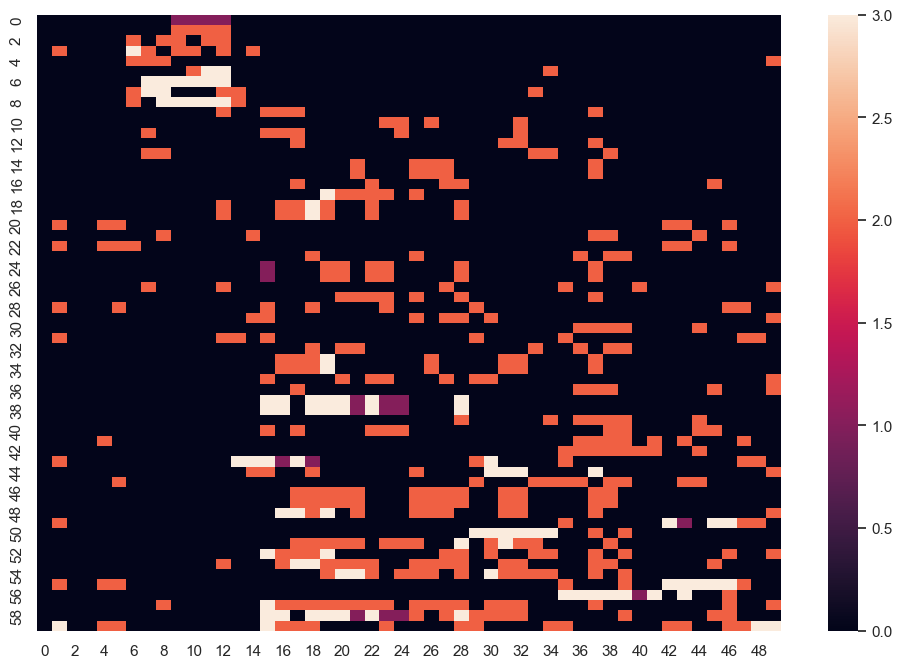

In [135]:
sns.heatmap(sorted(list(word2interaction.values()), key=lambda x: (x*np.arange(len(x))).sum()))
plt.show()

In [68]:
# build w2v model
glove_vectors = gensim.downloader.load('glove-twitter-25')

### NMF

K=03: Coherence=0.9053
K=04: Coherence=0.9137
K=05: Coherence=0.9213
K=06: Coherence=0.9250
K=07: Coherence=0.9136
K=08: Coherence=0.9071
K=09: Coherence=0.9052


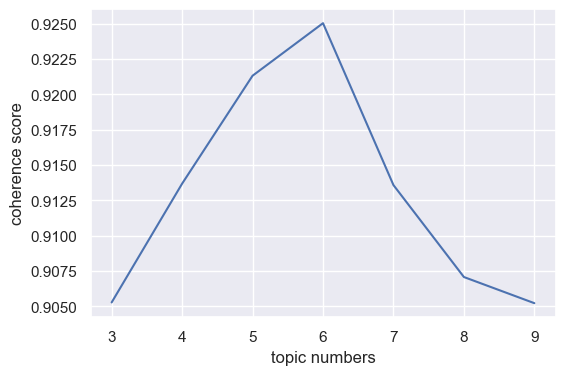

In [70]:
# run NMF
# model selection 
criteria = [] # [(N, loss)]
topic_models = []
X = np.array(list(word2interaction.values()))

for N in range(3, 10):
    # N = 6
    model = NMF(n_components=N, init='random', random_state=0).fit(X)
    W = model.fit_transform( X )
    H = model.components_    
    # store for later
    topic_models.append( (N,W,H) )

Ns, coherences = get_coherence_scores(topic_models)

criteria = list(zip(Ns, coherences))
criteria = sorted(criteria, key=lambda x: x[1], reverse=True)

N = criteria[0][0]
model = NMF(n_components=N, init='random', random_state=0).fit(X)
W = model.fit_transform(X)
H = model.components_

# plot the loss-N graph
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(x=[n for n, c in criteria], y=[c for n, c in criteria], ax=ax)

plt.xlabel('topic numbers')
plt.ylabel('coherence score')

plt.show()


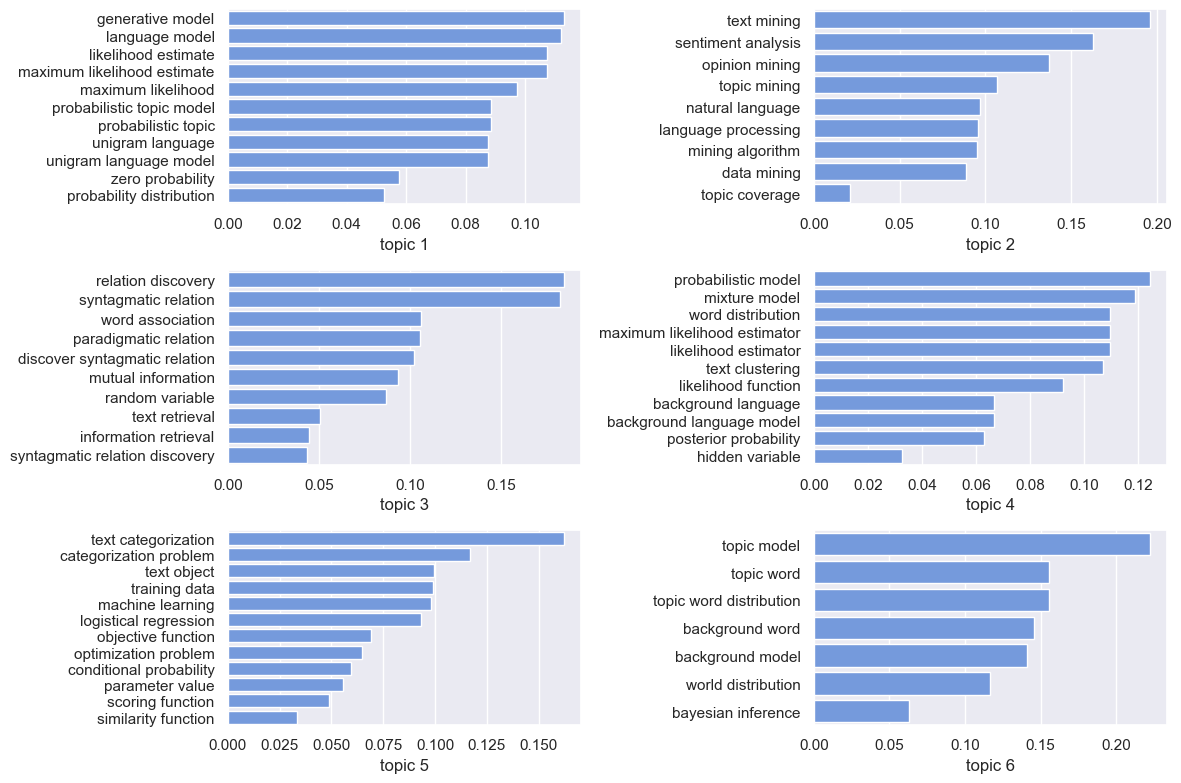

In [28]:
# visualization for phrases
# phrase topics
phrases = np.array(list(word2interaction.keys()))
topic2phrases = {}
topic2weights = {}
topicIdx = W.argmax(axis=1)
topicWeight = W.max(axis=1)
for i in range(N):
    topic2phrases[i] = phrases[np.where(topicIdx==i)]
    topic2weights[i] = topicWeight[topicIdx==i]
# topic2phrases

fig, axes = plt.subplots((N+1)//2, 2, figsize=(12, 8))
axes = axes.flatten()
for topicId in range(N):
    idx = topic2weights[topicId].argsort()[::-1]
    sns.barplot(x=topic2weights[topicId][idx]/topic2weights[topicId][idx].sum(), 
    y=topic2phrases[topicId][idx], ax=axes[topicId], color='cornflowerblue')
    axes[topicId].set_xlabel('topic %d'%(topicId+1))
    # axes[topicId].set_ylabel('phrases')

plt.tight_layout()
plt.show()

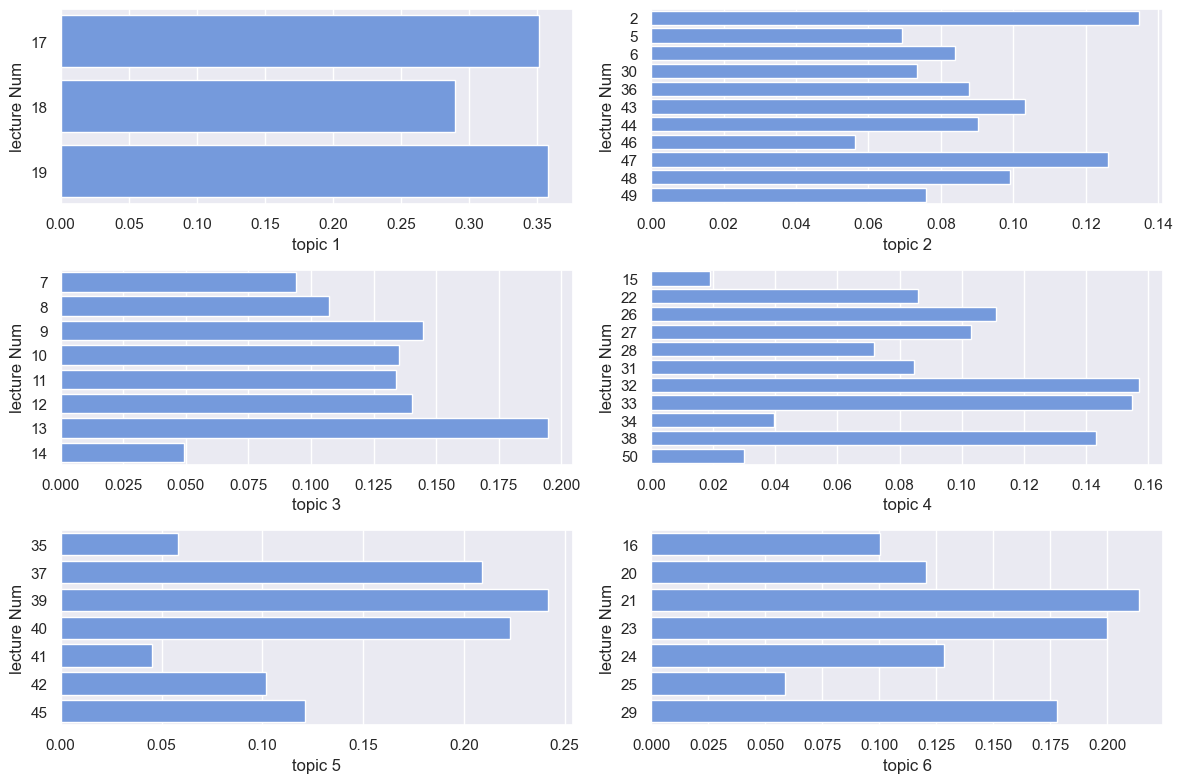

In [29]:
# visualization for lectures
# lecture topics
lectureId = np.arange(1, 51)
topic2lecId = {}
topicIdx = H.argmax(axis=0)
topicWeight = H.max(axis=0)
for i in range(N):
    topic2lecId[i] = lectureId[np.where(topicIdx==i)]
    topic2weights[i] = topicWeight[topicIdx==i]
topic2lecId

topic2lecId[0] = topic2lecId[0][3:]
topic2weights[0] = topic2weights[0][3:]
topic2lecId

fig, axes = plt.subplots((N+1)//2, 2, figsize=(12, 8))
axes = axes.flatten()
for topicId in range(N):
    # idx = topic2weights[topicId].argsort()[::-1]
    idx = np.arange(len(topic2weights[topicId]))
    sns.barplot(x=topic2weights[topicId][idx]/topic2weights[topicId][idx].sum(),
                y=topic2lecId[topicId][idx].astype(str),
                ax=axes[topicId], color='cornflowerblue')
    axes[topicId].set_xlabel('topic %d' % (topicId+1))
    axes[topicId].set_ylabel('lecture Num')

plt.tight_layout()
plt.show()


### LDA

In [21]:
# run NMF
# model selection 
# criteria = [] # [(N, loss)]
# X = np.array(list(word2interaction.values()))

# for N in range(6, 7):
#     # N = 6
#     model = LatentDirichletAllocation(n_components=N, random_state=0).fit(X)
#     criteria.append((N, model.reconstruction_err_))

# criteria = sorted(criteria, key=lambda x: x[1], reverse=True)
# N = criteria[0][0]

# plot the loss-N graph
# sns.lineplot(x=[n for n, c in criteria], y=[c for n, c in criteria])
# plt.show()

N = 6
model = LatentDirichletAllocation(n_components=N, random_state=0).fit(X)
W = model.fit_transform(X)
H = model.components_


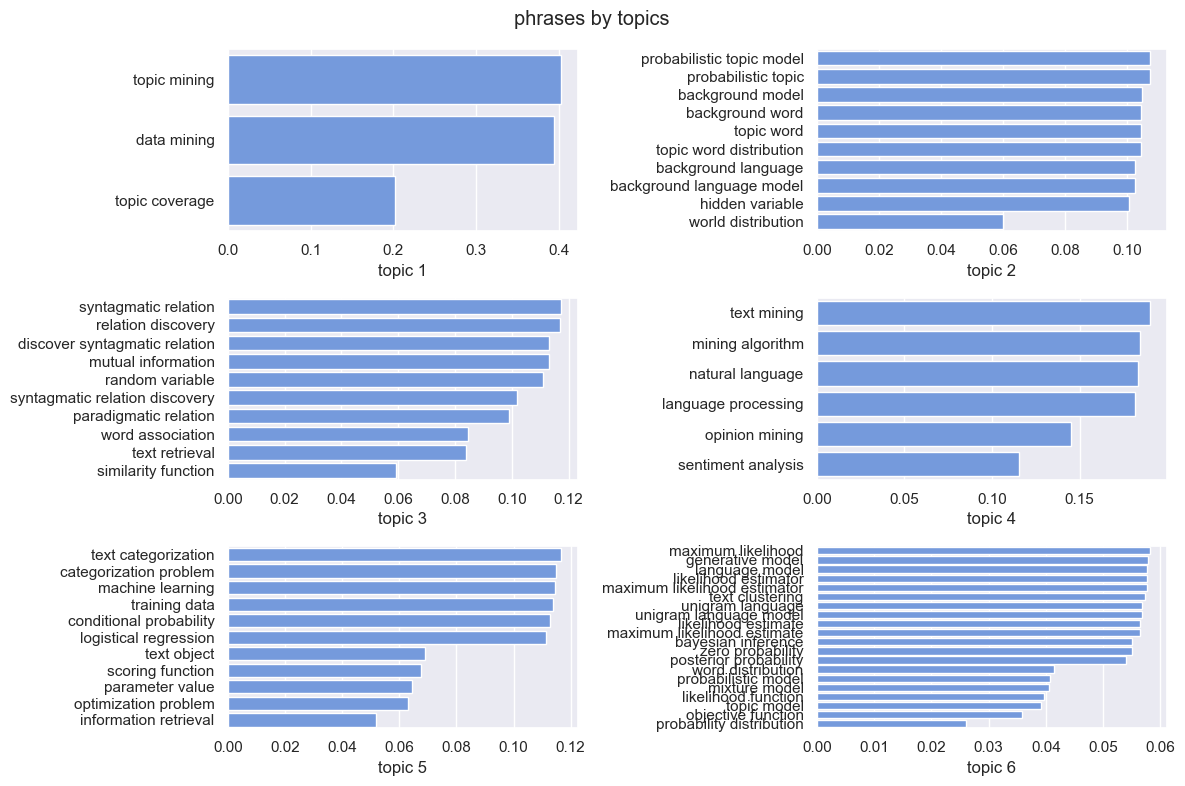

In [25]:
# visualization for phrases
# phrase topics
phrases = np.array(list(word2interaction.keys()))
topic2phrases = {}
topic2weights = {}
topicIdx = W.argmax(axis=1)
topicWeight = W.max(axis=1)
for i in range(N):
    topic2phrases[i] = phrases[np.where(topicIdx==i)]
    topic2weights[i] = topicWeight[topicIdx==i]
# topic2phrases

fig, axes = plt.subplots((N+1)//2, 2, figsize=(12, 8))
axes = axes.flatten()
for topicId in range(N):
    idx = topic2weights[topicId].argsort()[::-1]
    sns.barplot(x=topic2weights[topicId][idx]/topic2weights[topicId][idx].sum(), 
    y=topic2phrases[topicId][idx], ax=axes[topicId], color='cornflowerblue')
    axes[topicId].set_xlabel('topic %d'%(topicId+1))
    # axes[topicId].set_ylabel('phrases')

plt.suptitle('phrases by topics')
plt.tight_layout()
plt.show()

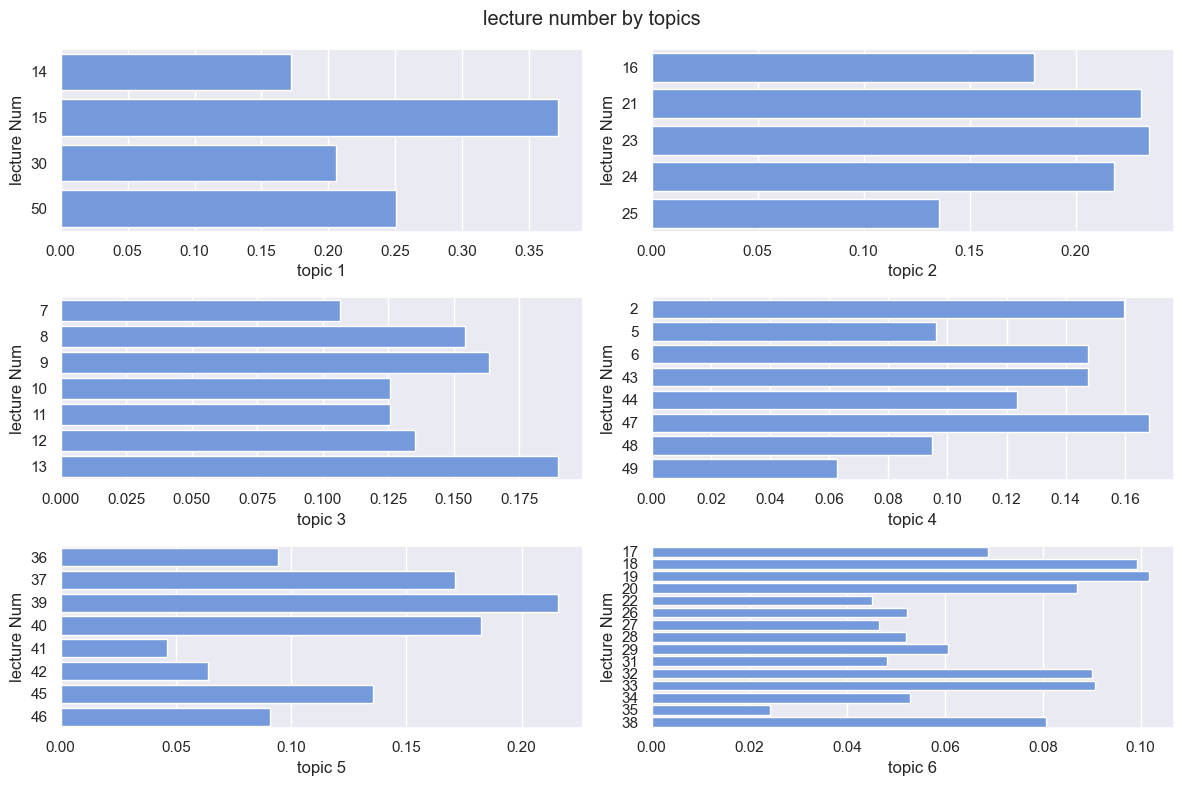

In [26]:
# visualization for lectures
# lecture topics
lectureId = np.arange(1, 51)
topic2lecId = {}
topicIdx = H.argmax(axis=0)
topicWeight = H.max(axis=0)
for i in range(N):
    topic2lecId[i] = lectureId[np.where(topicIdx==i)]
    topic2weights[i] = topicWeight[topicIdx==i]
topic2lecId

topic2lecId[0] = topic2lecId[0][3:]
topic2weights[0] = topic2weights[0][3:]
topic2lecId

fig, axes = plt.subplots((N+1)//2, 2, figsize=(12, 8))
axes = axes.flatten()
for topicId in range(N):
    # idx = topic2weights[topicId].argsort()[::-1]
    idx = np.arange(len(topic2weights[topicId]))
    sns.barplot(x=topic2weights[topicId][idx]/topic2weights[topicId][idx].sum(),
                y=topic2lecId[topicId][idx].astype(str),
                ax=axes[topicId], color='cornflowerblue')
    axes[topicId].set_xlabel('topic %d' % (topicId+1))
    axes[topicId].set_ylabel('lecture Num')

plt.suptitle('lecture number by topics')
plt.tight_layout()
plt.show()


### error analysis

In [43]:

df_temp = pd.DataFrame({}, columns=['topic_id', 'lec_number', 'title',
                                    'phrase_both', 'phrase_caption', 'phrase_video'])

for topicNum in range(N):
    for lecNum in topic2lecId[topicNum]:
        df_temp.loc[len(df_temp)] = topicNum, lecNum, lecNum2lecTitle[lecNum], \
            lecNum2phrasesBoth[lecNum], lecNum2phrasesCaption[lecNum], lecNum2phrasesVideo[lecNum]

# df_temp.to_excel('lecture_topics.xlsx', index=False)
df_temp

,topic_id,lec_number,title,phrase_both,phrase_caption,phrase_video
0,0,17,Lecture 17 — Probabilistic Topic Models Overv...,"language model, topic model, probabilistic top...","maximum likelihood estimate, likelihood estima...","unigram lm, simple language, simple language m..."
1,0,18,Lecture 18 — Probabilistic Topic Models Overv...,"language model, maximum likelihood, topic mining","maximum likelihood estimate, likelihood estima...","statistical language, statistical language model"
2,0,19,Lecture 19 — Probabilistic Topic Models Minin...,"maximum likelihood estimate, topic model, like...","objective function, optimization problem, unig...","mining one topic, simple case, one topic, topi..."
3,1,2,Lecture 2 — Overview Text Mining and Analytics...,text mining,"language processing, opinion mining, word asso...","overview text mining, overview text"
4,1,5,Lecture 5 — Text Representation - Part 1 | UIUC,,"language processing, text mining, sentiment an...",text representation
5,1,6,Lecture 6 — Text Representation - Part 2 | UIUC,,"language processing, text mining, text object,...",text representation
6,1,30,Lecture 30 — Text Clustering Motivation | UIUC,text clustering,"topic model, clustering result, text mining, t...",
7,1,36,Lecture 36 — Text Categorization Motivation | ...,text categorization,"training example, information retrieval, categ...","keyword text, predefined category, multiple un..."
8,1,43,Lecture 43 — Opinion Mining and Sentiment Anal...,"opinion mining, sentiment analysis","text mining, natural language, opinion holder,...","different kind, implicit holder, text datum"
9,1,44,"Lecture 44 — Opinion Mining, Sentiment Analysi...","text categorization, sentiment analysis","language processing, text mining, text object,...","task definition, text feature, sentiment class..."


### interactive NMF

In [9]:
def plot_topics(n=6):
    # run NMF
    N = n
    X = np.array(list(word2interaction.values()))
    model = NMF(n_components=N, init='random', random_state=0)
    W = model.fit_transform(X)
    H = model.components_

    # visualization for phrases
    # phrase topics
    phrases = np.array(list(word2interaction.keys()))
    topic2phrases = {}
    topic2weights = {}
    topicIdx = W.argmax(axis=1)
    topicWeight = W.max(axis=1)
    for i in range(N):
        topic2phrases[i] = phrases[np.where(topicIdx == i)]
        topic2weights[i] = topicWeight[topicIdx == i]
    # topic2phrases

    fig, axes = plt.subplots(N, 2, figsize=(12, 8*2))
    # fig.canvas.width = '100%'
    # fig.canvas.height = '500px'
    # axes = axes.flatten()

    for topicId in range(N):
        idx = topic2weights[topicId].argsort()[::-1]
        sns.barplot(x=topic2weights[topicId][idx]/topic2weights[topicId][idx].sum(),
                    y=topic2phrases[topicId][idx], ax=axes[topicId][0], color='cornflowerblue')
        axes[topicId][0].set_xlabel('topic %d' % (topicId+1))
        axes[topicId][0].set_ylabel('phrases')

    # visualization for lectures
    # lecture topics
    lectureId = np.arange(1, 51)
    topic2lecId = {}
    topicIdx = H.argmax(axis=0)
    topicWeight = H.max(axis=0)
    for i in range(N):
        topic2lecId[i] = lectureId[np.where(topicIdx==i)]
        topic2weights[i] = topicWeight[topicIdx==i]
    topic2lecId

    topic2lecId[0] = topic2lecId[0][3:]
    topic2weights[0] = topic2weights[0][3:]
    topic2lecId

    for topicId in range(N):
        # idx = topic2weights[topicId].argsort()[::-1]
        idx = np.arange(len(topic2weights[topicId]))
        sns.barplot(x=topic2weights[topicId][idx]/topic2weights[topicId][idx].sum(),
                    y=topic2lecId[topicId][idx].astype(str),
                    ax=axes[topicId][1], color='orange')
        axes[topicId][1].set_xlabel('topic %d' % (topicId+1))
        axes[topicId][1].set_ylabel('lecture Num')

    # plt.tight_layout()
    # plt.show()

def test(n=4):
    print(n)
    # pass
    # return n

In [10]:
_ = interact(plot_topics, n=widgets.IntSlider(min=2, max=10, step=1, value=6));

interactive(children=(IntSlider(value=6, description='n', max=10, min=2), Output()), _dom_classes=('widget-int…

## Segment-level

### Load Data

In [4]:
df_phrase = pd.read_csv(phrase_file, sep='\t').fillna('')

df_phrase['lecture_number'] = df_phrase['transcriptionid'].apply(lambda x: tid2lecNum[x])

df_phrase.head(2)

,transcriptionid,videoid,phrases_both,phrases_caption,phrases_video,lecture_number
0,0313c4b8-b3cb-47c4-893c-bcb27ce990a3,6bcd8791-b067-4442-b1c5-690b51547ecf,,"peter mutex lock, mutex lock, whole load, main...",,13-Q07
1,040bf74d-c21b-4d61-a0f9-38e3b2cc4d67,cc52fb01-ec70-48ed-ac3c-0d0f5009aee9,,"condition variable, peter mutex lock, mutex lo...",,13-Q06


In [5]:
tid2lecNum

{'0313c4b8-b3cb-47c4-893c-bcb27ce990a3': '13-Q07',
 '040bf74d-c21b-4d61-a0f9-38e3b2cc4d67': '13-Q06',
 '1e783a67-b8be-40c2-9441-09e0f8e0a1f8': '13-Q07',
 '34f5f15f-13e2-472c-a71d-7653231e61e9': '13-Q06',
 '7515c79a-82da-4b96-90bc-a6cbb5ee3e36': '13-Q01',
 'c4e34ebf-4fec-4220-80f0-55bff9d28117': '13-Q09',
 'fbf50bc7-ae3a-4768-be0b-502c42ec38cc': '13-Q07',
 '1df72ccf-c3d4-4939-945b-2a60fbbe7490': '14-Q02',
 '48c308bd-22a2-405e-9437-75a1df1794fe': '14-Q03',
 '6c7e145f-442c-430a-a17d-cd3630fbce96': '14-Q07',
 '798dfc68-4c27-4294-b5d2-be44d2f85516': '14-Q06',
 '868deb37-9bd1-4419-a9ac-e164d0b078da': '14-Q04',
 'a73bb722-a006-40e7-ba5b-1402cd135b37': '14-Q05',
 'b681599f-1223-4f55-aca4-e57ac7b4b6cd': '14-Q05',
 'baa2188b-1097-4e5f-9fed-2ae8b4b6eff9': '14-Q08',
 'c13af5c8-7804-4b6a-ab8f-1f0d32ac4c29': '14-Q07',
 'da7958fa-52cd-4d05-93a6-42c5aaca70a7': '14-Q05',
 '068de9f9-f0f5-4140-8da8-7ba0ac3aa5c3': '15-Q02',
 '079e15d0-be66-4f0c-a3b4-bb9079ea8eea': '15-Q03',
 '160c1e41-f1c4-4ca1-9264-636d9

In [6]:
# phrase_file = 'CS_410/tid2phrasewindow.json'
phrase_file = 'CS_241/tid2phrasewindow.json'
text_file = 'CS_241/tid2textwindow.json'

tid2phraseWindow = json.load(open(phrase_file, 'r'))
tid2textWindow = json.load(open(text_file, 'r'))
lecNum2window = {tid2lecNum[k]: tid2phraseWindow[k] for k in tid2phraseWindow if k in tid2lecNum}
lecNum2text = {tid2lecNum[k]: tid2textWindow[k] for k in tid2textWindow if k in tid2lecNum}
lecNum2maxTime = {tid2lecNum[k]: len(tid2phraseWindow[k]) for k in tid2phraseWindow if k in tid2lecNum}

# lecNum2window

seg2window = {}
for k in lecNum2window:
    for idx, s in enumerate(lecNum2window[k]):
        if len(s) > 0:
            seg2window[str(k) + '_' + str(idx)] = s

seg2window

{'18-Q03_0': ['pizza slice', 'mutex lock'],
 '18-Q03_2': ['counting semaphore', 'pizza slice'],
 '09-Q05_0': ['link list'],
 '09-Q05_1': ['link list'],
 '09-Q05_3': ['link list'],
 '09-Q05_4': ['link list'],
 '09-Q05_5': ['link list'],
 '09-Q05_6': ['link list'],
 '09-Q05_7': ['link list'],
 '09-Q05_9': ['link list'],
 '09-Q05_10': ['memory address', 'link list', 'memory location'],
 '33-Q01_0': ['network card', 'web server', 'port number'],
 '33-Q01_1': ['address info', 'port number', 'ip four address'],
 '33-Q01_2': ['file descriptor', 'network card', 'port number'],
 '33-Q01_3': ['file descriptor', 'link list', 'return value'],
 '07-Q02_0': ['whole lot'],
 '07-Q02_1': ['memory address'],
 '07-Q02_4': ['c library'],
 '07-Q02_8': ['c code'],
 '24-Q04_0': ['standard error'],
 '24-Q04_1': ['standard error'],
 '24-Q04_3': ['write code'],
 '18-Q02_0': ['p thread mutex', 'thread mutex', 'mutex lock'],
 '18-Q02_1': ['network card'],
 '18-Q02_2': ['counting semaphore'],
 '13-Q07_0': ['race c

In [7]:
word_count = Counter()
for k in seg2window:
    word_count+=(Counter(seg2window[k]))

word_count

Counter({'pizza slice': 9,
         'mutex lock': 125,
         'counting semaphore': 19,
         'link list': 65,
         'memory address': 35,
         'memory location': 32,
         'network card': 11,
         'web server': 47,
         'port number': 31,
         'address info': 18,
         'ip four address': 7,
         'file descriptor': 96,
         'return value': 36,
         'whole lot': 25,
         'c library': 44,
         'c code': 28,
         'standard error': 22,
         'write code': 24,
         'p thread mutex': 21,
         'thread mutex': 30,
         'race condition': 26,
         'whole load': 32,
         'main memory': 14,
         'peter mutex': 12,
         'peter mutex lock': 11,
         'web page': 27,
         'condition variable': 38,
         'file handle': 25,
         'virtual memory': 22,
         'address space': 23,
         'thread condition': 16,
         'thread exit': 16,
         'p thread condition': 12,
         'p threat condition': 

In [8]:
word2interaction = {}
for w, c in word_count.most_common(60):
    inters = []
    for k in seg2window:
        if w in seg2window[k]:
            inters.append(1)
        else:
            inters.append(0)

    word2interaction[w] = inters

# convert to array
word2interaction = {k: np.array(word2interaction[k]) for k in word2interaction}

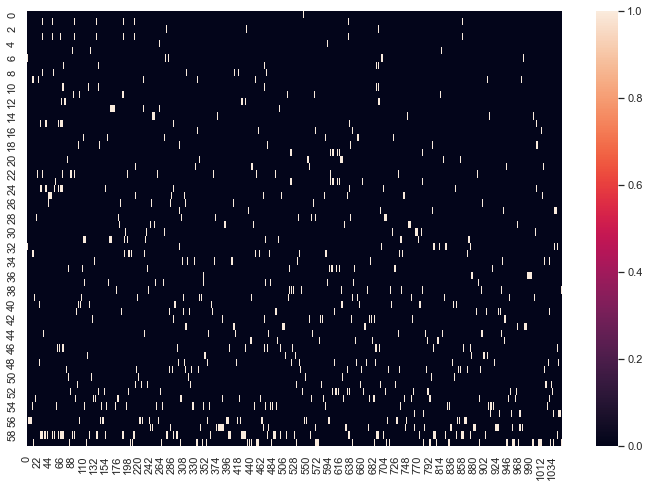

In [9]:
sns.heatmap(sorted(list(word2interaction.values()), key=lambda x: (x*np.arange(len(x))).sum()))
plt.show()

In [33]:
# build w2v model
# glove_vectors = gensim.downloader.load('glove-twitter-25')

### NMF

{'semaphore', 'cpu', 'condition', 'code', 'memory', 'mutex', 'time', 'main', 'race', 'threat', 'counting', 'write', 'lock', 'p', 'peter'}
{'review', 'buffer', 'semaphore', 'condition', 'code', 'variable', 'threat', 'load', 'counting', 'write', 'ring', 'thread', 'p', 'whole', 'peter'}
{'information', 'web', 'block', 'link', 'time', 'meta', 'cpu', 'error', 'whole', 'file', 'c', 'system', 'standard', 'disk', 'write', 'browser', 'code', 'load', 'symbolic'}
{'review', 'buffer', 'pointer', 'text', 'code', 'condition', 'variable', 'mutex', 'dot', 'void', 'ring', 'threat', 'lock', 'handle', 'thread', 'p', 'file'}
{'address', 'exclusive', 'heap', 'pointer', 'code', 'memory', 'link', 'access', 'void', 'main', 'lot', 'load', 'four', 'list', 'ip', 'whole', 'c'}
{'location', 'port', 'system', 'address', 'block', 'virtual', 'memory', 'number', 'space', 'main', 'heat', 'page', 'disk', 'operating', 'table'}
{'info', 'port', 'tcp', 'address', 'web', 'text', 'dot', 'server', 'number', 'network', 'card',

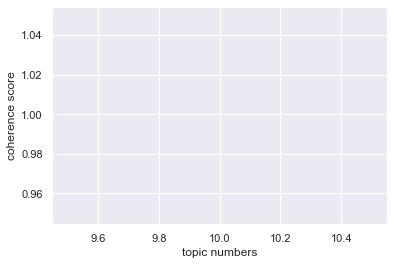

In [10]:
# run NMF
# model selection 
criteria = [] # [(N, loss)]
topic_models = []
X = np.array(list(word2interaction.values()))

for N in range(10, 11):
    # N = 6
    model = NMF(n_components=N, init='random', random_state=0).fit(X)
    W = model.fit_transform( X )
    H = model.components_    
    # store for later
    topic_models.append( (N,W,H) )

Ns, coherences = get_coherence_scores(topic_models)

criteria = list(zip(Ns, coherences))
criteria = sorted(criteria, key=lambda x: x[1], reverse=True)

N = criteria[0][0]
model = NMF(n_components=N, init='random', random_state=0).fit(X)
W = model.fit_transform(X)
H = model.components_

# plot the loss-N graph
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(x=[n for n, c in criteria], y=[c for n, c in criteria], ax=ax)

plt.xlabel('topic numbers')
plt.ylabel('coherence score')

plt.show()


In [11]:
def get_topic_centroids(topic_id, max_n=3):
    topic_id = topic_id - 1
    idx = topic2weights[topic_id].argsort()[::-1][topic2weights[topic_id]>0.1]
    return topic2phrases[topic_id][idx][:max_n]

# get_topic_centroids(2)

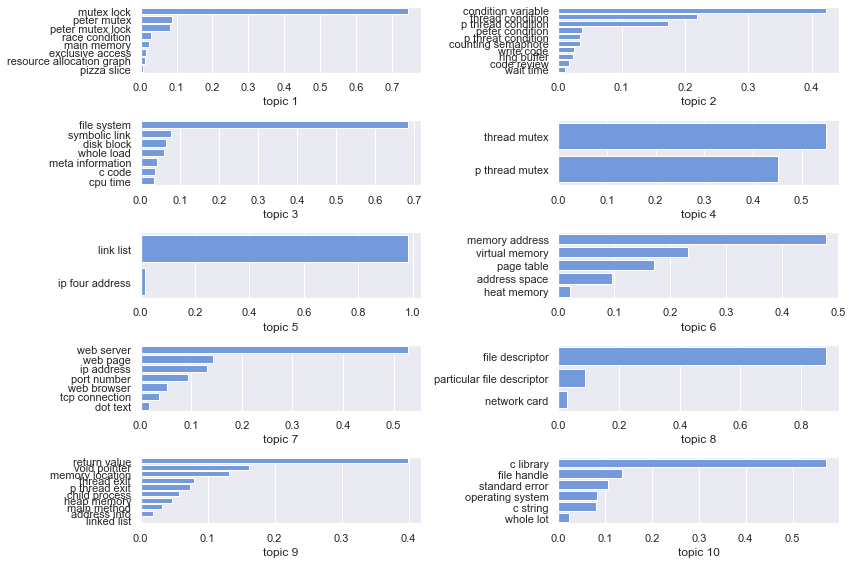

In [12]:
# visualization for phrases
# phrase topics
# weightThreshold = 0.1

phrases = np.array(list(word2interaction.keys()))
topic2phrases = {}
topic2weights = {}
topicIdx = W.argmax(axis=1)
topicWeight = W.max(axis=1)
for i in range(N):
    topic2phrases[i] = phrases[np.where(topicIdx==i)]
    topic2weights[i] = topicWeight[topicIdx==i]
# topic2phrases

fig, axes = plt.subplots((N+1)//2, 2, figsize=(12, 8))
axes = axes.flatten()
for topicId in range(N):
    idx = topic2weights[topicId].argsort()[::-1]
    sns.barplot(x=topic2weights[topicId][idx]/topic2weights[topicId][idx].sum(), 
    y=topic2phrases[topicId][idx], ax=axes[topicId], color='cornflowerblue')
    axes[topicId].set_xlabel('topic %d'%(topicId+1))
    # axes[topicId].set_ylabel('phrases')

plt.tight_layout()
plt.show()

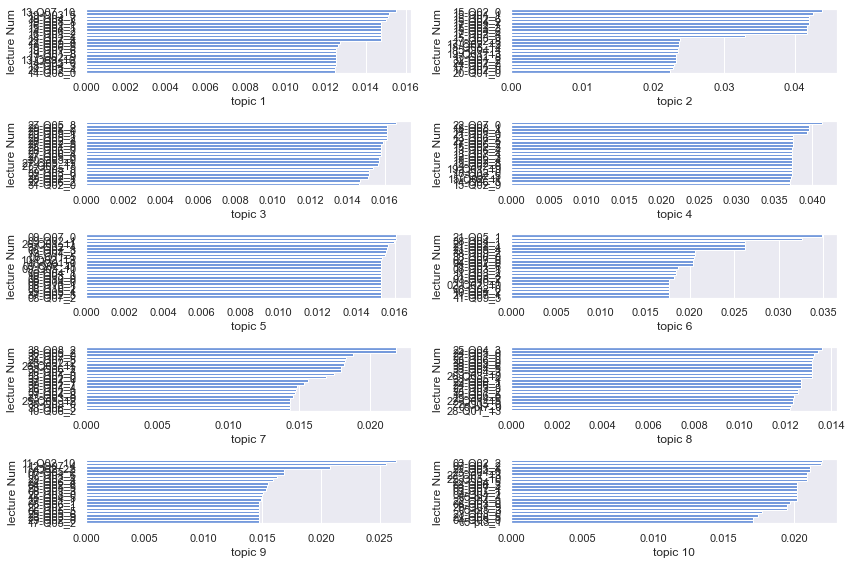

In [13]:
# visualization for lectures
# lecture topics
LecPerGraph = 20
# weightThreshold = 0.1
lectureId = np.array(list(seg2window.keys()))

topic2lecId = {}
topicIdx = H.argmax(axis=0)
topicWeight = H.max(axis=0)
for i in range(N):
    topic2lecId[i] = lectureId[np.where(topicIdx==i)]
    topic2weights[i] = topicWeight[topicIdx==i]
topic2lecId

# topic2lecId[0] = topic2lecId[0][3:]
# topic2weights[0] = topic2weights[0][3:]
# topic2lecId

fig, axes = plt.subplots((N+1)//2, 2, figsize=(12, 8))
axes = axes.flatten()
for topicId in range(N):
    idx = topic2weights[topicId].argsort()[::-1]
    # idx = np.arange(len(topic2weights[topicId]))
    sns.barplot(x=(topic2weights[topicId][idx]/topic2weights[topicId][idx].sum())[:LecPerGraph],
                y=topic2lecId[topicId][idx].astype(str)[:LecPerGraph],
                ax=axes[topicId], color='cornflowerblue')
    axes[topicId].set_xlabel('topic %d' % (topicId+1))
    axes[topicId].set_ylabel('lecture Num')

plt.tight_layout()
plt.show()


### interactive NMF

In [80]:
def plot_topics(n=6):
    # run NMF
    N = n
    X = np.array(list(word2interaction.values()))
    model = NMF(n_components=N, init='random', random_state=0)
    W = model.fit_transform(X)
    H = model.components_

    # visualization for phrases
    # phrase topics
    phrases = np.array(list(word2interaction.keys()))
    topic2phrases = {}
    topic2weights = {}
    topicIdx = W.argmax(axis=1)
    topicWeight = W.max(axis=1)
    for i in range(N):
        topic2phrases[i] = phrases[np.where(topicIdx == i)]
        topic2weights[i] = topicWeight[topicIdx == i]
    # topic2phrases

    fig, axes = plt.subplots(N, 2, figsize=(12, 8*2))
    # fig.canvas.width = '100%'
    # fig.canvas.height = '500px'
    # axes = axes.flatten()

    for topicId in range(N):
        idx = topic2weights[topicId].argsort()[::-1]
        sns.barplot(x=topic2weights[topicId][idx]/topic2weights[topicId][idx].sum(),
                    y=topic2phrases[topicId][idx], ax=axes[topicId][0], color='cornflowerblue')
        axes[topicId][0].set_xlabel('topic %d' % (topicId+1))
        axes[topicId][0].set_ylabel('phrases')

    # visualization for lectures
    # lecture topics
    LecPerGraph = 20
    # weightThreshold = 0.1
    lectureId = np.array(list(seg2window.keys()))
    topic2lecId = {}
    topicIdx = H.argmax(axis=0)
    topicWeight = H.max(axis=0)
    for i in range(N):
        topic2lecId[i] = lectureId[np.where(topicIdx==i)]
        topic2weights[i] = topicWeight[topicIdx==i]
    topic2lecId

    topic2lecId[0] = topic2lecId[0][3:]
    topic2weights[0] = topic2weights[0][3:]
    topic2lecId

    for topicId in range(N):
        idx = topic2weights[topicId].argsort()[::-1]
        # idx = np.arange(len(topic2weights[topicId]))
        sns.barplot(x=(topic2weights[topicId][idx]/topic2weights[topicId][idx].sum())[:LecPerGraph],
                    y=topic2lecId[topicId][idx].astype(str)[:LecPerGraph],
                    ax=axes[topicId][1], color='orange')
        axes[topicId][1].set_xlabel('topic %d' % (topicId+1))
        axes[topicId][1].set_ylabel('lecture Num')

    plt.tight_layout()
    plt.show()


In [81]:
_ = interact(plot_topics, n=widgets.IntSlider(min=2, max=10, step=1, value=6));

interactive(children=(IntSlider(value=6, description='n', max=10, min=2), Output()), _dom_classes=('widget-int…

### topic to segment mapping 

In [14]:
from treelib import Node, Tree

In [15]:
topic2lecId

{0: array(['18-Q03_0', '13-Q07_8', '13-Q07_10', '13-Q06_1', '13-Q06_6',
        '13-Q06_7', '16-Q01_1', '16-Q01_2', '16-Q01_4', '16-Q01_6',
        '15-Q03_2', '19-Q03_1', '19-Q03_5', '39-Q04_0', '39-Q04_7',
        '18-Q04_3', '20-Q03_0', '15-Q04_1', '15-Q04_3', '18-Q01_2',
        '19-Q08_4', '19-Q08_8', '14-Q02_2', '14-Q02_3', '14-Q02_4',
        '35-Q07_5', '17-Q03_0', '17-Q03_1', '18-Q06_0', '18-Q06_1',
        '18-Q06_3', '18-Q06_5', '18-Q06_8', '18-Q08_0', '18-Q08_2',
        '18-Q08_8', '18-Q08_9', '18-Q08_11', '15-Q05_0', '15-Q05_1',
        '15-Q05_3', '20-Q06_1', '17-Q06_5', '17-Q06_6', '19-Q01_6',
        '19-Q01_8', '19-Q01_9', '19-Q01_11', '19-Q01_12', '15-Q06_0',
        '15-Q06_1', '15-Q06_2', '15-Q06_3', '15-Q06_4', '15-Q06_5',
        '20-Q07_0', '20-Q07_1', '20-Q07_5', '18-Q05_1', '18-Q05_6',
        '14-Q07_3', '13-Q01_0', '13-Q01_6', '14-Q06_1', '14-Q06_2',
        '17-Q02_6', '17-Q02_9', '16-Q02_7', '14-Q05_0', '24-Q02_1',
        '24-Q02_3', '24-Q02_4', '24-Q02_6

In [16]:
weightThreshold = 0.1

lectureId = np.array(list(seg2window.keys()))
topic2lecId = {}
topic2lecWeights = {}
topicIdx = H.argmax(axis=0)
topicWeight = H.max(axis=0)
for i in range(N):
    topic2lecId[i] = lectureId[np.where(topicIdx == i)]
    topic2lecWeights[i] = topicWeight[topicIdx == i]

# get weights for phrases
phrases = np.array(list(word2interaction.keys()))
topic2phrases = {}
topic2PhraseWeights = {}
topicIdx = W.argmax(axis=1)
topicWeight = W.max(axis=1)
for i in range(N):
    topic2phrases[i] = phrases[np.where(topicIdx == i)]
    topic2PhraseWeights[i] = topicWeight[topicIdx == i]
# topic2phrases

# filter out the lectures with low weight
topic2lecIdFiltered = {k: sorted(
    v[topic2lecWeights[k] > 0.1],
    #  key=lambda x: [int(s) for s in x.split('_')])
    key=lambda x: [int(s) for s in x.split('_')[0].replace(
        '-pt', '-Q').replace('Q03-05', 'Q03').split('-Q')]  # CS 241, consider segments
)
    for k, v in topic2lecId.items()}


# unpack the hierarchical structure: topic -> lecture -> segment
topic2lec2seg = {}
for topicId in topic2lecIdFiltered:
    for segID in topic2lecIdFiltered[topicId]:
        # lecNum, segNum = [int(s) for s in segID.split('_')]
        # CS 241, consider segments
        lecNum, segNum = [s for s in segID.split('_')]
        if topicId not in topic2lec2seg:
            topic2lec2seg[topicId] = {}
        if lecNum not in topic2lec2seg[topicId]:
            topic2lec2seg[topicId][lecNum] = []
        topic2lec2seg[topicId][lecNum].append(segNum)


# topic2lec2seg

# visualise the hierarchy

def get_topic_centroids(topic_id, max_n=3):
    topic_id = topic_id
    idx = topic2PhraseWeights[topic_id].argsort(
    )[::-1][topic2PhraseWeights[topic_id] > 0.1]
    return topic2phrases[topic_id][idx][:max_n].tolist()


def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)


def draw(parent_name, child_name):
    tmpId = str(uuid.uuid1())
    graph.add_node(pydot.Node(tmpId, label=child_name))
    edge = pydot.Edge(parent_name, tmpId)
    graph.add_edge(edge)


def visit(node, parent=None):
    for k, v in node.items():
        graph.add_node(pydot.Node(k, label=k))
        graph.add_edge(pydot.Edge(parent, k))
        if isinstance(v, dict):
            # We start with the root node whose parent is None
            # we don't want to graph the None node
            if parent:
                draw(parent, k)
            visit(v, k)
        elif isinstance(v, list):
            for i in v:
                draw(k, i)


# add description to the names for better visualization
topic2lec2seg_desc = topic2lec2seg.copy()
for topicId in list(topic2lec2seg_desc.keys()):
    for lecNum in list(topic2lec2seg_desc[topicId].keys()):
        for idx, segNum in enumerate(topic2lec2seg_desc[topicId][lecNum]):
            topic2lec2seg_desc[topicId][lecNum][idx] = '%s minute' % (segNum)
        topic2lec2seg_desc[topicId]["lecture " +
                                    str(lecNum)] = topic2lec2seg_desc[topicId].pop(lecNum)
    topic2lec2seg_desc["topic " +
                       str(topicId+1)] = topic2lec2seg_desc.pop(topicId)

all_graphs = []
for i in range(N):
    topicName = 'topic %s' % (i+1)
    graph = pydot.Dot(graph_type='digraph', rankdir='LR', dpi=150)
    graph.set_node_defaults(
        # color='lightgray',
        # style='filled',
        shape='box',
        # fontname='Courier',
        # fontsize='10'
    )
    # the topic node
    node_from = pydot.Node(topicName,
                           label=topicName + ": %s"
                           % ', '.join(get_topic_centroids(i, max_n=3)))
    # label is the displayed name of the node
    graph.add_node(node_from)
    visit(topic2lec2seg_desc[topicName], parent=topicName)
    graph.write_png('dot_plots/%s.png' % topicName)
    # view_pydot(graph)

    nx_graph = nx.drawing.nx_pydot.from_pydot(graph)
    all_graphs.append(nx_graph)

graph_all_json = json_graph.node_link_data(nx.compose_all(all_graphs))

with open('topic_graph_CS241.json', 'w') as f:
    json.dump(graph_all_json, f)


In [17]:
# plot timeline for each lecture
import plotly.graph_objects as go

all_lectures = set()
for d in topic2lec2seg_desc.values():
    all_lectures.update(d.keys())
all_lectures = sorted(all_lectures, key=lambda x: x.split(' ')[1])

fig = go.Figure()

# all_lectures

In [19]:
def newlineEvery(n, s):
    s = s.replace('-pron-', ',')
    return '<br>    '.join(s[i:i+n] for i in range(0, len(s), n))
    # return s

plot_lecNum = 'lecture 25'

counter = 0
min_time = 0
for lecName in all_lectures:
    if lecName.startswith(plot_lecNum):
        x = []
        counter += 1
        labels = []
        for topicId in topic2lec2seg_desc:
            if lecName in topic2lec2seg_desc[topicId]:
                x.extend([int(text.split()[0])
                        for text in topic2lec2seg_desc[topicId][lecName]])
                labels.extend(
                    # todo: get the caption of the segment here
                    # [t + newlineEvery(80, lecNum2text[int(lecName.split(' ')[1])][i]) 
                    [t + newlineEvery(80, lecNum2text[lecName.split(' ')[1]][i]) # CS 241, consider segments
                    for i, t in enumerate([
                        '<b>' + topicId + '</b>'
                        + ': <br>    '
                        + '; '.join(get_topic_centroids(int(topicId.split()[1])-1))
                        + '<br>'
                        + '<b>caption</b>: <br>    '
                    ] * len(topic2lec2seg_desc[topicId][lecName]))])
        y = [counter] * len(x)

        x.append(0)
        y.append(counter)
        labels.append('Start')

        # x.append(lecNum2maxTime[int(lecName.split(' ')[1])])
        x.append(lecNum2maxTime[lecName.split(' ')[1]]) # CS 241, consider segments
        y.append(counter)
        labels.append('End')

        fig.add_trace(go.Scatter(
            x=x,
            y=y,
            name=lecName,
            text=labels,
            yaxis="y",
        ))

fig.update_layout(
    # font_family="Courier New",
    # font_color="blue",
    # title_font_family="Times New Roman",
    # title_font_color="red",
    # legend_title_font_color="green",
    title_text="CS 241 Lecture Concept Timeline",
    width=1200,
    height=800,
)
fig.show()
# fig.write_html("plotly_plots/CS_241_L25.html")

In [44]:
# Dump data to json
topicKeywords2lec2seg = topic2lec2seg_desc.copy()
lecName2tid = {'lecture ' + tid2lecNum[k]: k for k in tid2lecNum}

for topicId in topicKeywords2lec2seg:
    # get lecture captions
    captions = {}
    for lecName in topic2lec2seg_desc[topicId]:
        minuteIdx = [int(s.split()[0]) for s in topic2lec2seg_desc[topicId][lecName]]
        texts = [s.replace('-pron-', ',') for s in tid2textWindow[lecName2tid[lecName]]]
        captions[lecName] = list(map(texts.__getitem__, minuteIdx))

    topicKeywords2lec2seg[topicId] = {
        'keywords': get_topic_centroids(int(topicId.split()[1])-1, max_n=3),
        'mentions': topic2lec2seg_desc[topicId],
        'captions': captions,
        }
with open('lecture_concept_timeline_CS_241.json', 'w') as f:
    json.dump(topicKeywords2lec2seg, f, indent=2)

In [31]:
topic2lec2seg_desc[topicId]

{'lecture 02-Q01': ['1 minute'],
 'lecture 02-Q02': ['0 minute', '5 minute'],
 'lecture 02-Q12': ['0 minute'],
 'lecture 03-Q02': ['2 minute'],
 'lecture 03-Q04': ['1 minute'],
 'lecture 03-Q06': ['0 minute', '1 minute', '2 minute', '3 minute'],
 'lecture 03-Q07': ['1 minute', '2 minute', '3 minute', '4 minute'],
 'lecture 03-Q10': ['5 minute'],
 'lecture 04-Q02': ['7 minute', '13 minute'],
 'lecture 04-Q03': ['0 minute'],
 'lecture 04-Q04': ['0 minute', '2 minute', '4 minute'],
 'lecture 04-Q05': ['0 minute',
  '3 minute',
  '5 minute',
  '7 minute',
  '9 minute',
  '15 minute'],
 'lecture 04-Q06': ['5 minute', '6 minute'],
 'lecture 04-Q07': ['5 minute'],
 'lecture 05-pt2': ['3 minute', '5 minute'],
 'lecture 05-pt3': ['0 minute', '1 minute', '2 minute'],
 'lecture 05-pt4': ['3 minute', '5 minute'],
 'lecture 05-pt5': ['2 minute', '3 minute', '10 minute'],
 'lecture 05-pt7': ['1 minute', '3 minute', '6 minute'],
 'lecture 06-Q04': ['4 minute'],
 'lecture 07-Q01': ['2 minute',
  '3 mi

In [81]:
topic2lec2seg_desc

{'topic 1': {'lecture 13-Q01': ['0 minute', '6 minute'],
  'lecture 13-Q06': ['1 minute', '6 minute', '7 minute'],
  'lecture 13-Q07': ['8 minute', '10 minute'],
  'lecture 13-Q09': ['0 minute', '9 minute', '10 minute', '11 minute'],
  'lecture 14-Q02': ['2 minute', '3 minute', '4 minute'],
  'lecture 14-Q05': ['0 minute'],
  'lecture 14-Q06': ['1 minute', '2 minute'],
  'lecture 14-Q07': ['3 minute'],
  'lecture 14-Q08': ['0 minute'],
  'lecture 15-Q03': ['2 minute'],
  'lecture 15-Q04': ['1 minute', '3 minute'],
  'lecture 15-Q05': ['0 minute', '1 minute', '3 minute'],
  'lecture 15-Q06': ['0 minute',
   '1 minute',
   '2 minute',
   '3 minute',
   '4 minute',
   '5 minute'],
  'lecture 16-Q01': ['1 minute', '2 minute', '4 minute', '6 minute'],
  'lecture 17-Q01': ['5 minute'],
  'lecture 17-Q02': ['6 minute', '9 minute'],
  'lecture 17-Q06': ['5 minute', '6 minute'],
  'lecture 18-Q01': ['2 minute'],
  'lecture 18-Q03': ['0 minute'],
  'lecture 18-Q04': ['3 minute'],
  'lecture 18-Q